In [1]:
using Plots
using LinearAlgebra
using Random
using Distributions

In [3]:
# Example data
Random.seed!(1234)  # determinism

# controlled-conditioning matrix
function rand_cond_mat(m::Int64, s::Float64)
    X = randn(m, 6)
    X[:, 3] = X[:, 1] + 3 * X[:, 2] + randn(m) / s
    X[:, 6] = X[:, 4] + 5 * X[:, 5] + randn(m) / s
    X = [X ones(m)]
    X ./= maximum(svdvals(X))  # Scale so that || X ||_2 = 1
    return X
end

# Get sample-feature matrices and linear systems
m = 100
scales = 10.0 .^ (1:7)
As = [rand_cond_mat(m, s) for s in scales]
r = 1e-1 * randn(m)
xtrue = randn(size(As[1], 2))
bs = [A * xtrue + r for A in As];

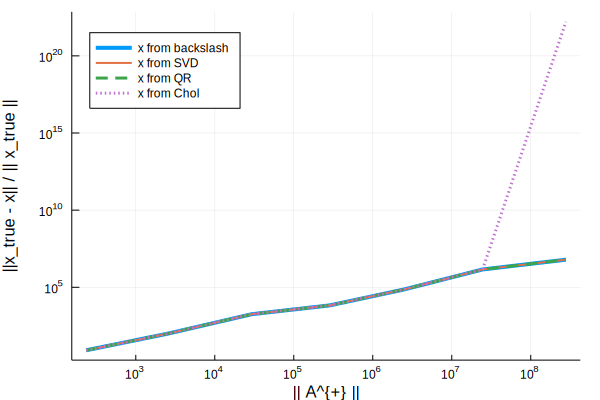

In [28]:
# Linear least squares solvers
ls_bs(A::Array{Float64,2}, b::Vector{Float64}) = A \ b
function ls_chol(A::Array{Float64,2}, b::Vector{Float64})
    L = cholesky(A' * A, check=false).U'
    return L' \ (L \ (A' * b))
end
function ls_qr(A::Array{Float64,2}, b::Vector{Float64})
    Q, R = qr(A)
    return R \ (Matrix(Q)' * b)
end
function ls_svd(A::Array{Float64,2}, b::Vector{Float64})
    U, Σ, V = svd(A)
    return V * (Diagonal(Σ) \ (U' * b))
end

# Solutions
xhat_bs   = [ls_bs(  A, b) for (A, b) in zip(As, bs)]
xhat_chol = [ls_chol(A, b) for (A, b) in zip(As, bs)]
xhat_qr   = [ls_qr(  A, b) for (A, b) in zip(As, bs)]
xhat_svd  = [ls_svd( A, b) for (A, b) in zip(As, bs)]

# Difference with xtrue
ntrue = norm(xtrue)
bs_diff   = [norm(x - xtrue) / ntrue for x in xhat_bs]
chol_diff = [norm(x - xtrue) / ntrue for x in xhat_chol]
qr_diff   = [norm(x - xtrue) / ntrue for x in xhat_qr]
svd_diff  = [norm(x - xtrue) / ntrue for x in xhat_svd]

conds = [opnorm(pinv(A),2) for A in As]
plot(conds,  bs_diff,   lw=4,
     xlabel="|| A^{+} ||", ylabel="||x_true - x|| / || x_true ||", 
     xscale=:log10, yscale=:log10, 
     label="x from backslash", legend=:topleft)
plot!(conds, svd_diff,  lw=2, label="x from SVD")
plot!(conds, qr_diff,   lw=3, ls=:dash, label="x from QR")
plot!(conds, chol_diff, lw=3, ls=:dot,  label="x from Chol")

In [5]:
xtrue

7-element Array{Float64,1}:
  0.0491768366956024 
 -0.32861816975014313
  0.2904507529392771 
  0.7901729169975822 
 -2.145585558650008  
  0.360037013947867  
  0.2642843869523987 

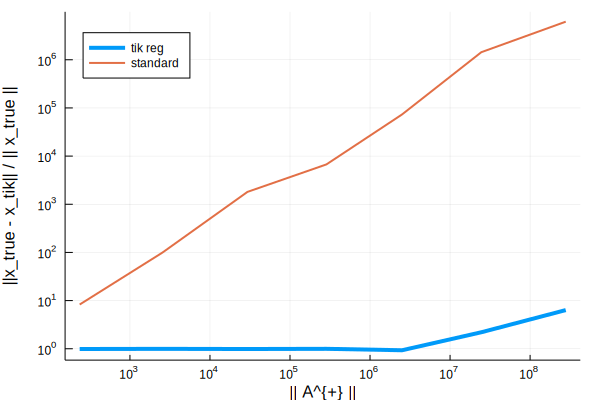

In [30]:
# Tikhonov regularization
function ls_svd_tik(A::Array{Float64,2}, b::Vector{Float64}, λ::Float64)
    U, Σ, V = svd(A)
    FΣ = Σ ./ (Σ .^ 2 .+ λ^2)
    return V * (Diagonal(FΣ) \ (U' * b))
end

λ = 0.001
xhat_svd_tik  = [ls_svd_tik(A, b, λ) for (A, b) in zip(As, bs)]
svd_tik_diff  = [norm(x - xtrue) / ntrue for x in xhat_svd_tik]
plot(conds,  svd_tik_diff,   lw=4,
     xlabel="|| A^{+} ||", ylabel="||x_true - x_tik|| / || x_true ||", 
     xscale=:log10, yscale=:log10, label="tik reg", legend=:topleft)
plot!(conds, svd_diff,  lw=2, label="standard")

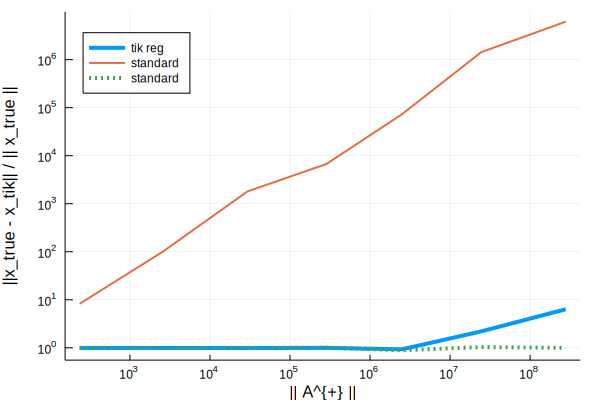

In [31]:
# Truncated SVD
function ls_svd_trunc(A::Array{Float64,2}, b::Vector{Float64}, ϵ::Float64)
    U, Σ, V = svd(A)
    k = findfirst(z -> z < ϵ, Σ)
    if   k == nothing k = length(Σ)
    else              k -= 1
    end
    return V[:,1:k] * (Diagonal(Σ[1:k]) \ (U[:,1:k]' * b))
end

ϵ = svdvals(As[1])[4] * (1 + 1e-8)
xhat_svd_trunc  = [ls_svd_trunc(A, b, ϵ) for (A, b) in zip(As, bs)]
svd_trunc_diff  = [norm(x - xtrue) / ntrue for x in xhat_svd_trunc]
plot!(conds, svd_trunc_diff,  lw=4, ls=:dot, label="standard")

In [52]:
using ScikitLearn
@sk_import linear_model : Lasso
@sk_import linear_model : lars_path

PyObject <function lars_path at 0x1260a1c80>

In [50]:
function lasso_solve(A::Array{Float64,2}, b::Vector{Float64}, λ::Float64)
    model = Lasso(alpha=λ,             # amount of regularization
                  fit_intercept=false  # we already have intercepts
                 )
    fit!(model, A, b)  
    return model[:coef_]
end

for xhat_lasso in [lasso_solve(A, b, 0.00001) for (A, b) in zip(As, bs)]
    println(xhat_lasso)
end

[0.0, 0.588731, 0.275398, 1.04421, -0.0, -0.0107091, 0.0224719]
[0.043703, -0.0, 0.0424702, 0.647073, 0.0, 0.0537966, 0.100035]
[0.0, -0.0, -0.0715882, 1.81559, -0.0, -0.104297, 0.0371628]
[-0.54174, 0.0, 0.379678, 0.317579, 0.0, 0.102489, 0.418377]
[-0.142344, 0.0, 0.0903556, 1.03103, -0.0, -0.124814, 0.263869]
[0.0998885, -0.0, -0.115608, -0.19108, -0.0, -0.00653309, 0.214435]
[0.0187265, -0.0, 0.0211652, 1.35993, -0.0, -0.00345032, 0.151555]


In [63]:
pts, _, all_coeffs = lars_path(As[end], bs[end], method="lasso")
plot(pts, zeros(length(pts)), lw=2, color="black", xscale=:log10)
for ind = 1:size(all_coeffs, 1)
    @show pts, vec(all_coeffs[ind, :])
    plot!(pts, vec(all_coeffs[ind, :]), label="$(ind)")
end

(pts, vec(all_coeffs[ind, :])) = ([0.000690077, 0.000482802, 0.000143405, 0.000136141, 6.44048e-5, 2.2313e-5, 1.73447e-5, 3.41102e-12], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0442575])
(pts, vec(all_coeffs[ind, :])) = ([0.000690077, 0.000482802, 0.000143405, 0.000136141, 6.44048e-5, 2.2313e-5, 1.73447e-5, 3.41102e-12], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
(pts, vec(all_coeffs[ind, :])) = ([0.000690077, 0.000482802, 0.000143405, 0.000136141, 6.44048e-5, 2.2313e-5, 1.73447e-5, 3.41102e-12], [0.0, 0.0, 0.0, 0.00154662, 0.0175469, 0.0220657, 0.0222758, 0.0196412])
(pts, vec(all_coeffs[ind, :])) = ([0.000690077, 0.000482802, 0.000143405, 0.000136141, 6.44048e-5, 2.2313e-5, 1.73447e-5, 3.41102e-12], [0.0, 0.0, 0.99782, 1.01857, 1.21832, 1.32354, 1.33821, 1.38952])
(pts, vec(all_coeffs[ind, :])) = ([0.000690077, 0.000482802, 0.000143405, 0.000136141, 6.44048e-5, 2.2313e-5, 1.73447e-5, 3.41102e-12], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
(pts, vec(all_coeffs[ind, :])) = ([0.000690077, 0

MethodError: MethodError: no method matching getindex(::Tuple{Array{Float64,1},Array{Int64,1},Array{Float64,2}}, ::Symbol)
Closest candidates are:
  getindex(::Tuple, !Matched::Int64) at tuple.jl:24
  getindex(::Tuple, !Matched::Real) at tuple.jl:25
  getindex(::Tuple, !Matched::AbstractUnitRange{#s72} where #s72<:Real) at range.jl:287
  ...